# Find clear scenes in high-resolution SST

### Choose a target region and time period, cycle through all available high-resolution sea surface temperature data, identify clear images, catalog them 

https://github.com/NASA-Openscapes/nch2021-projects-contexdata

- This builds on biavillasboas's notebook
- We will use L3 VIIRS SST here, PO.DAAC short name "VIIRS_NPP-OSPO-L3U-v2.61"


Issues/to-do:

1. Processing a year of data consumes all the memory on a small cloud instance (when xr.open_mfdataset() is called)
1. It seems like I am hitting a limit of the number of granules that can be returned by using requests.get to query 'https://cmr.earthdata.nasa.gov/search/granules'
1. It would be nice to print/save a list of clear dates

## Summary of what I learned 

1. Cloud computing is just using someone else’s computer.
1. The place where there is an advantage to be had is when you can do cloud computing next to a huge amount of data
1. If you must work locally, or on a different cloud than where the data are, data sets in the cloud are functionally just data sets on the web
1. We can query the NASA Common Metadata Repository to find out the names and “concept ID” of datasets (url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'); see example below in this notebook
1. To download data (to cloud or local machine), you need a _netrc file (on windows) or .netrc file (on linux) to pass NASA EarthData credentials and get S3 access;—see Tutorial 4, https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb ; this is needed in “def begin_s3_direct_access()” below; for direct download, it would also be needed
1. We were working in the Amazon Cloud using the “2i2c Hub Service”:
https://openscapes.2i2c.cloud/hub/login?next=%2Fhub%2F


In [1]:
#!conda install -y -c conda-forge s3fs numpy pandas xarray matplotlib cartopy

In [2]:
#!conda install -y -c conda-forge h5netcdf dask netCDF4 bottleneck

In [ ]:
#conda install -y -c conda-forge cartopy=0.21

In [3]:
#Pretty sure some of these are extraneous
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

# import geoviews as gv
# import hvplot.xarray
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')

warnings.filterwarnings("ignore")

%matplotlib inline
# %matplotlib qt5

## Set some parameters (start/end time)


In [4]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 700

## PO DAAC Catalog exploration using the CMR API

- The search is restricted to colections that have data over a given time window

In [5]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 500,
                            'temporal': ['2021-10-01T10:00:00Z','2021-11-01T00:00:00Z'] 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

'241'

### Loop through each response in the catalog and print the respective concept ID

These are the data sets that cover the time period of interest

In [6]:
#  This will show short names and concept ids for all PO.DAAC data sets at this time
if False:
    for r in response.json()['items']:
        print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

### Loading credentials for direct access

In [7]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [8]:
# Center location
site = 'S-MODE'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [9]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2016-8-20T00:00:00Z'
    end_time = '2017-11-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'



Maybe try these:

https://podaac.jpl.nasa.gov/dataset/VIIRS_NPP-STAR-L3U-v2.80  
'C2147485059-POCLOUD' #VIIRS_NPP-STAR-L3U-v2.80

https://podaac.jpl.nasa.gov/dataset/VIIRS_N20-STAR-L3U-v2.80  
'C2147488020-POCLOUD' #VIIRS_N20-STAR-L3U-v2.80

In [10]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

# VIIRS_NPP-OSPO-L2P-v2.61 ==>  C1996880725-POCLOUD
concept_id = 'C2036880650-POCLOUD' #  MODIS
concept_id = 'C2147478146-POCLOUD' #'C1996880725-POCLOUD' # VIIRS_NPP-OSPO-L2P-v2.61 
# concept_id = 'C2036877595-POCLOUD' # VIIRS_NPP-OSPO-L3U-v2.61 
concept_id = 'C2147488020-POCLOUD' #VIIRS_N20-STAR-L3U-v2.80
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
96


In [11]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][1]['href'])
# granules_url
len(granules_url)

96

In [12]:
gran['links']#['rel'=='http://esipfed.org/ns/fedsearch/1.1/s3#'];

[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
  'title': 'Download 20211105222000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
  'hreflang': 'en-US',
  'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211105222000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
  'title': 'This link provides direct download access via S3 to the granule',
  'hreflang': 'en-US',
  'href': 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211105222000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/metadata#',
  'title': 'Download 20211105222000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc.md5',
  'hreflang': 'en-US',
  'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/VIIRS_N20-STAR-L3U-v2.80/20211105222000-STAR-L3U_GHRSST-S

## There is an inconvenient issue with these files.  The correct link is not in the same place for each of the granules

This was an attempt to fix the issue by just dropping the md5 suffix.  That almost works, but the prefix should be something like:  
s3://podaac-ops-cumulus-protected/ 

and not:  
s3://podaac-ops-cumulus-public/

In [13]:
granules_url2 = []
for gran in granules_url:
    #print(gran.replace('.md5',''))
    gran2 = gran.replace('.md5','')
    #print(gran2[gran2.index('/VIIRS'):])
    granules_url2.append('s3://podaac-ops-cumulus-protected'+gran2[gran2.index('/VIIRS'):])


In [14]:
granules_url2

['s3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211020092000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211020110000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211020190000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211020204000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211020222000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211021090000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',
 's3://podaac-ops-cumulus-protected/VIIRS_N20-STAR-L3U-v2.80/20211021104000-STAR-L3U_GHRSST-SSTsubskin-VIIRS_N20-ACSPO_V2.80-v02.0-fv01.0.nc',

## Plot all SST images available during the S-MODE windows and pick good days

Load in the data with xarray.open_mfdataset().  The one trick for the s3 access here is to use list comprehension to modify the list of granule URLs into a list of open s3 files before passing to xr.open_mfdataset().  

_(Is that description correct??)_

In [15]:
# This loads a single file
ds = xr.open_dataset(fs.open(granules_url[1]),drop_variables=['dt_analysis','satellite_zenith_angle','sses_bias','wind speed']).sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))

In [16]:
file_list =  [fs.open(file) for file in granules_url2]

In [17]:
ds = xr.open_mfdataset(file_list,drop_variables=['dt_analysis','satellite_zenith_angle','sses_bias','wind speed']).sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))

In [18]:
#  Plot the whole timeseries with hvplot

#sst = ds.sea_surface_temperature-273.15
#sst.hvplot(groupby='time', width=600, height=400, clim=(10, 20), cmap='plasma')

As expected, there are lots of times with no useful data.  (There is an interactive plot above, but it may not render in a static view.)

## Make a metric to select times with clear skies in region of interest

The idea here is to choose a box defining region of interest and use quality flag or NaN mask to count bad/good pixels


In [19]:
# Define a box where we want data (may be different than larger analysis domain)
# Still centered on lon0,lat0
dlon = 0.5 # half of box width in lon
dlat = 0.5 # half of box width in lat

# Define the max/min lon
x1 = lon0 - dlon
x2 = lon0 + dlon
y1 = lat0 - dlat
y2 = lat0 + dlat

In [20]:
# Make a time series in that box
# Compute mean value of "not NaN" (notnull) in the box
good_data = ds.sea_surface_temperature.sel(lat=slice(y2,y1), lon=slice(x1,x2)).notnull().mean({'lon','lat'})
np.shape(good_data)

(96,)

Text(0.5, 1.0, 'Values near 1 indicate clear skies')

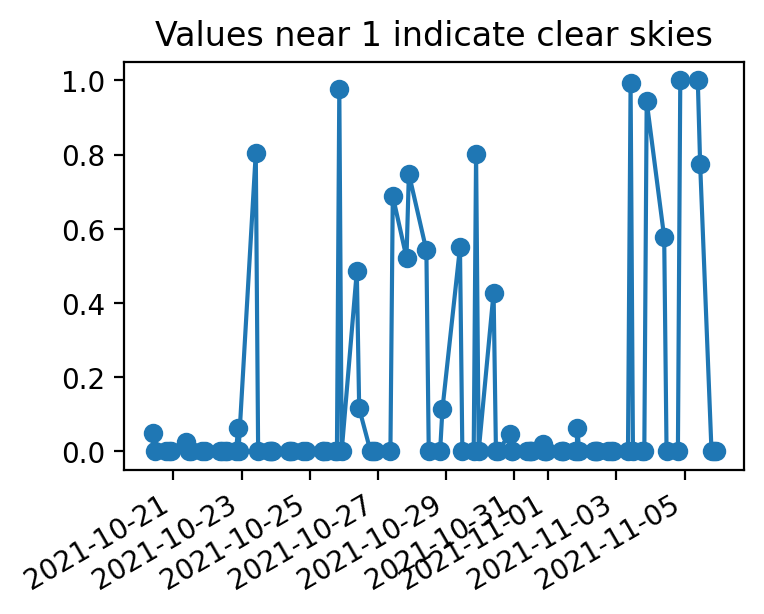

In [21]:
fig = plt.figure(figsize=(4,3),dpi=200)
plt.plot(good_data['time'],good_data,marker='o')
fig.autofmt_xdate()
plt.title('Values near 1 indicate clear skies')

In [22]:
good_times = good_data['time'].where(good_data>0.95,drop=True)
np.shape(good_times)

(4,)

In [23]:
good_times[-1].values

numpy.datetime64('2021-11-05T09:20:01.000000000')

## Choose a particular time


In [24]:
# Find the data near this time
d = good_times[-1] # np.datetime64('2021-11-05T00:00:00Z')

In [25]:
ds2 = ds.sel(time=d,method='nearest')

In [26]:
# This string of the time of the SST selected will be useful
day_str = np.datetime_as_string(ds2.time,unit='m')

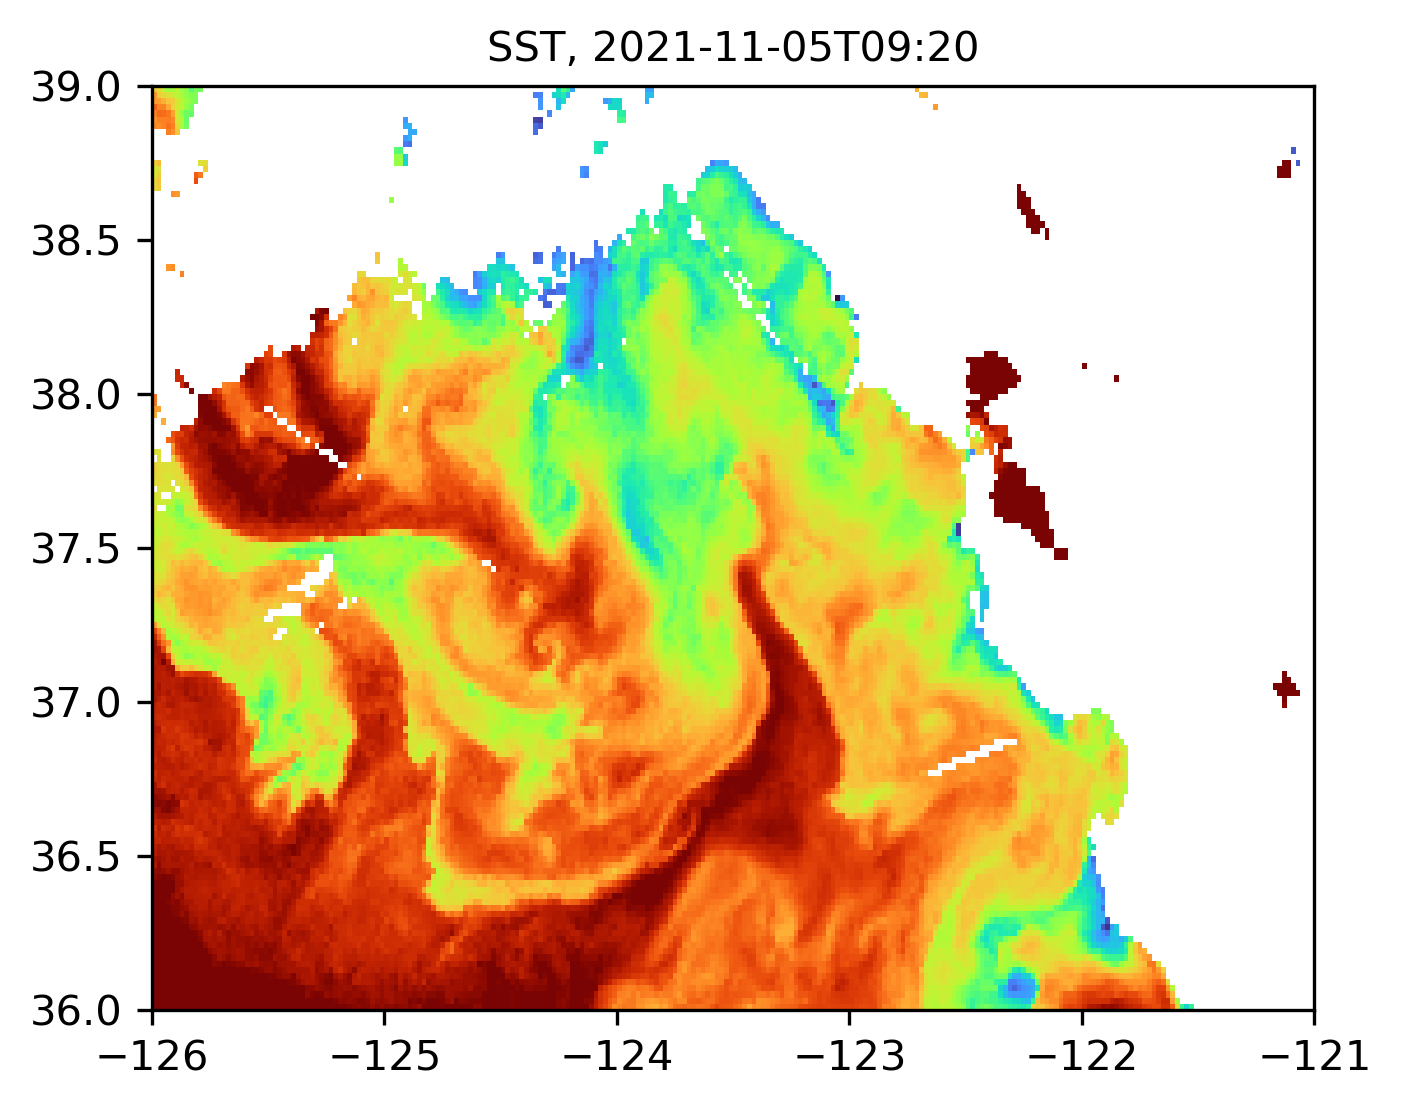

In [27]:
fig = plt.figure()
ax = plt.gca()
plt.set_cmap(cmap=plt.get_cmap('turbo'))
ax.set_title('SST, ' + day_str, size = 10.)

cs = plt.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze()-274.15,vmin=12.5,vmax=15)


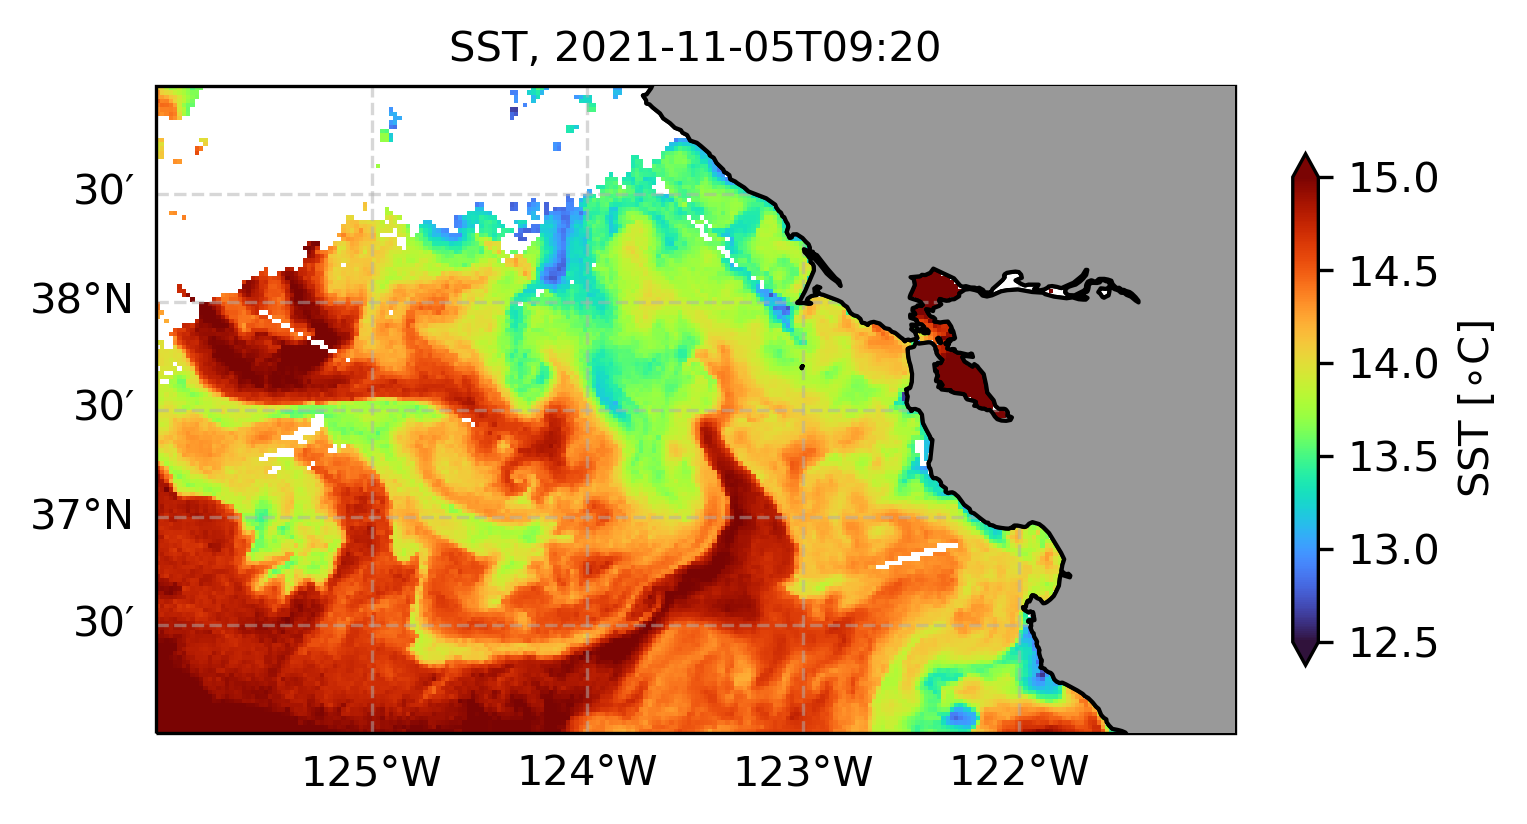

In [28]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SST, ' + day_str, size = 10.)

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze()-274.15,vmin=12.5,vmax=15,transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SST [$\circ$C]',fontsize = 10)
